<a href="https://colab.research.google.com/github/brunokrp/ai-protectionism/blob/main/exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXPLORATORY ANALYSIS**

Based on the Digital Policy Alert database, this exploratory analysis aims at using NLP tools to better understand how AI policies are distributed and what are the main terms used in their descriptions. The goal through this exploratory analysis is to figure out whether terms commonly related to economic protectionism are picked up, what those terms/topics are and which regions they are related to.

# **SETTING ENVIRONMENT**

#### **Installing libraries, importing them and connecting to Google Drive**

In [31]:
!pip install tomotopy --quiet

In [32]:
import pandas as pd
import tomotopy as tp
import seaborn as sns
import altair as alt
import numpy as np

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

import sklearn as skl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
# Connecting to folder through Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/"AI INDUSTRIAL POLICY"/"SIPA_TEXT"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AI INDUSTRIAL POLICY/SIPA_TEXT


# **DATA PROCESSING**

#### **Loading dataset, creating preprocessing functions and applying them**

In [62]:
# Loading dataset downloaded from the Digital Policy Alert website
digital_policies_df = pd.read_csv("digital_policies.csv")

# To ensure that I am not analyzing the same event twice, I drop the duplicates based on the event description
digital_policies_df.drop_duplicates(subset=['Latest Event Description'], inplace=True)

# I create a copy of the dataset to increase code reliability
dig_pol_df = digital_policies_df.copy()

In [63]:
# I load english stopwords from the NLTK corpus and include new stop words that are relevant to this analysis
stop_list = nltk.corpus.stopwords.words('english')
newStopWords = ['ai','artificial','intelligence', 'technology', 'system', 'systems', 'on', 'machine', 'learning', 'act', 'month', 'day', 'use', 'u', 'state'
                ,'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'approach', 'thresholds', 'report']
stop_list.extend(newStopWords)

# I load the lemmatizer function from NLTK and define a function to extract the POS tag for each word
# [Based on https://www.machinelearningplus.com/nlp/lemmatization-examples-python/ and https://github.com/rskrisel/intro_to_nltk/blob/main/Intro_NLTK_workshop.ipynb)]

lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()  # Get the first letter of the POS tag
    tag_dict = {
        'J': wordnet.ADJ,  # Adjective
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV    # Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if not found

# I define a function to preprocess text: tokenize, lowercase, exclude stop words, get POS and lemmatize
def preprocess_policies(text):
    text_tokens = nltk.word_tokenize(text)
    nltk_text = nltk.Text(text_tokens)
    text_lower = [t.lower() for t in nltk_text if t.isalpha()]
    text_stops = [t for t in text_lower if t not in stop_list]
    text_clean = [WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in text_stops]
    text_stops_lemma = [t for t in text_clean if t not in stop_list]

    return ' '.join(text_stops_lemma)

In [64]:
# Applying functions created above to clean policy descriptions
dig_pol_df['clean_event_description'] = dig_pol_df['Latest Event Description'].apply(preprocess_policies)

# Restrict dataset only for those policies that are related to ML and AI development, semiconductors and cloud computing. Check its length
ai_policies_df = dig_pol_df[(dig_pol_df['Economic Activities'].str.contains('ML and AI development|Semiconductors|cloud computing') == True)].reset_index()
print(len(ai_policies_df))

# Since the dataset is structured in the intervention-level, and each can be related to more than one country,
# I explode the dataset so that each line corresponds to an intervention-country pair.
# Check its length
ai_policies_df_per_country = ai_policies_df.assign(countries=ai_policies_df['Implementing Countries'].str.split(', ')).explode('countries').reset_index(drop=True)
print(len(ai_policies_df_per_country))

1062
8106


#### **Loading dataframe with regions/continents per country**

In [65]:
# Loading dataset and renaming column to facilitate joining later
cc_df = pd.read_csv('country_continent.csv')
cc_df = cc_df.rename(columns={'country':'countries'})

#### **Loading dataframe with clusters per country**

In [66]:
# Loading dataset and renaming column to facilitate joining later
%cd /content/drive/MyDrive/"AI INDUSTRIAL POLICY"/"SIPA_TEXT"/"ai_clusters"
df_clusters = pd.read_csv("ai_clusters_countries.csv", index_col="Unnamed: 0")
df_clusters = df_clusters.rename(columns={'Country':'countries'})

%cd /content/drive/MyDrive/"AI INDUSTRIAL POLICY"/"SIPA_TEXT"

/content/drive/MyDrive/AI INDUSTRIAL POLICY/SIPA_TEXT/ai_clusters
/content/drive/MyDrive/AI INDUSTRIAL POLICY/SIPA_TEXT



#### **Adjusting base dataset to enable cross-region analysis**

In [67]:
# Joining policy dataset with country dataset to obtain the region from each country
ai_policies_df_per_country = pd.merge(ai_policies_df_per_country,cc_df,on='countries', how='left')
print(len(ai_policies_df_per_country))

# Joining policy dataset with cluster dataset to obtain the cluster from each country
ai_policies_df_per_country = pd.merge(ai_policies_df_per_country, df_clusters, on='countries', how='left')
print(len(ai_policies_df_per_country))

ai_policies_df_per_country = ai_policies_df_per_country.drop(columns=["consumer_potential", "development_potential"])

8106
8106


# **TF-IDF AND TOPICS PER REGION**

## **TF-IDF**

#### **Running TF-IDF for each region**
 Because I want to understand which terms are more important for each region, I create subsets of data for each region and run TF-IDF on those subsets. Then, I plot a heatmap to visualize the distribution of terms per region.

In [68]:
### RUNNING TF-IDF ANALYSIS

# Creating copy of base dataframe
tfidf_df = ai_policies_df_per_country.copy()

# Creating empty dataframe
tf_idf_regions_terms = pd.DataFrame()

# Calculating TF_IDF for each subset and appending it to a dataset
list_regions = tfidf_df.region_1.dropna().unique()
for region in list_regions:
  subset = tfidf_df[tfidf_df['region_1'] == region]
  tfidf_vectorizer = TfidfVectorizer(input='content', stop_words=stop_list)
  tfidf_vector = tfidf_vectorizer.fit_transform(subset['Latest Event Description'])
  tfidf_df_subset = pd.DataFrame(tfidf_vector.toarray(), index=subset['Policy Change ID'], columns=tfidf_vectorizer.get_feature_names_out())
  tfidf_df_subset = tfidf_df_subset.stack().reset_index()
  tfidf_df_subset = tfidf_df_subset.rename(columns={0:'tfidf', 'level_1': 'term'})
  tf_idf_regions_terms = pd.concat([tf_idf_regions_terms, tfidf_df_subset])

# Filtering out the terms that have a low tfidf score (below 0.001)
tf_idf_regions_terms = tf_idf_regions_terms[tf_idf_regions_terms['tfidf'] > 0.001]

# Creating new dataset that contains unique pairs of intervention-region
tfidf_df_new = tfidf_df[['Policy Change ID', 'region_1']].drop_duplicates()

# Merging dataset that contains TF_IDF values with dataset that contains unique pairs of intervention-region
tf_idf_regions = pd.merge(tf_idf_regions_terms,tfidf_df_new,on='Policy Change ID')

# Getting top 10 terms with highest TF_IDF per region
top_tfidf = tf_idf_regions.sort_values(by=['region_1','tfidf'], ascending=[True,False]).drop_duplicates(subset=['term', 'region_1']).groupby(['region_1']).head(10)

In [69]:
### VISUALIZING TF-IDF HEATMAP
#[based on https://github.com/rskrisel/tf-idf/blob/main/README.md]

# Adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# Base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'region_1:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["region_1"],
)

# Heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# Text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# Display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

## **TOPIC MODELING**

#### **Training topic modeling model**

In [70]:
# Passing policy descriptions as a list
topic_training_data = ai_policies_df.clean_event_description.to_list()

# Defining the number of topics to return
num_topics = 8

# Defining the number of topic words to print out
num_topic_words = 10

# Initializing the model with seed to get always the same results
model = tp.LDAModel(k=num_topics, seed=42)

# Adding each document to the model, after removing white space (strip)
# and splitting it up into words (split)
for text in topic_training_data:
    model.add_doc(text.strip().split())

# Printing the log-likelihood function to
# derive the maximum likelihood estimator of the parameter
print("Topic Model Training...\n\n")

# Iterating over the data 40 times
iterations = 40
for i in range(0, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

print("\nTopic Model Results:\n\n")
# Printing out top 10 words for each topic
topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number+1}✨\n\n{topic_words}\n")

Topic Model Training...


Iteration: 0	Log-likelihood: -7.581507030345364
Iteration: 1	Log-likelihood: -7.493695987730095
Iteration: 2	Log-likelihood: -7.464114129558229
Iteration: 3	Log-likelihood: -7.441581269536054
Iteration: 4	Log-likelihood: -7.428933354076105


<ipython-input-70-40d2dcb3ada5>:25: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(iterations)


Iteration: 5	Log-likelihood: -7.428313134106953
Iteration: 6	Log-likelihood: -7.4181145066084415
Iteration: 7	Log-likelihood: -7.425687697991197
Iteration: 8	Log-likelihood: -7.415808159879553
Iteration: 9	Log-likelihood: -7.421224371926906
Iteration: 10	Log-likelihood: -7.417572736042145
Iteration: 11	Log-likelihood: -7.42373203386678
Iteration: 12	Log-likelihood: -7.419453381949495
Iteration: 13	Log-likelihood: -7.422617371255068
Iteration: 14	Log-likelihood: -7.427568627354448
Iteration: 15	Log-likelihood: -7.420053947266181
Iteration: 16	Log-likelihood: -7.408635242187451
Iteration: 17	Log-likelihood: -7.413724246337073
Iteration: 18	Log-likelihood: -7.41337260533669
Iteration: 19	Log-likelihood: -7.413625170365029
Iteration: 20	Log-likelihood: -7.413844737533853
Iteration: 21	Log-likelihood: -7.412673413377749
Iteration: 22	Log-likelihood: -7.415652382909972
Iteration: 23	Log-likelihood: -7.407084752063899
Iteration: 24	Log-likelihood: -7.413975548585996
Iteration: 25	Log-likeliho

#### **Visualizing topic modeling results**

In [71]:
# Creating a dataframe with the results
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]
ai_policies_topics = pd.DataFrame(topic_distributions)

# Joining the dataframe with results with the base dataset
ai_policies_df_topics = ai_policies_df.join(ai_policies_topics)

# Exploding dataset so that each obsevation is at the country-intervention level
ai_policies_country_topics = ai_policies_df_topics.assign(countries=ai_policies_df_topics['Implementing Countries'].str.split(', ')).explode('countries').reset_index(drop=True)

# Merging dataset with country dataset to obtain regions
ai_policies_country_topics = pd.merge(ai_policies_country_topics,cc_df[['countries', 'region_1']],on='countries')

# Renaming columns that refer to topics
dict_topics = {0:"topic_1", 1:"topic_2", 2:"topic_3", 3:"topic_4", 4:"topic_5", 5:"topic_6", 6:"topic_7", 7:"topic_8"}
ai_policies_country_topics = ai_policies_country_topics.rename(columns=dict_topics)

# Dropping column countries and keeping only regions
ai_policies_country_topics = ai_policies_country_topics.drop(columns='countries')

# Slicing dataset so that it contains only the region and topics
ai_policies_country_topics_only = ai_policies_country_topics.iloc[:,num_topics*(-1)-1:]

# Grouping dataset by region, getting the mean of each topic per region
ai_policies_country_topics = ai_policies_country_topics_only.groupby(['region_1']).mean()

# Creating a dataset to be used for visualization
hist_data = ai_policies_country_topics

<Axes: ylabel='region_1'>

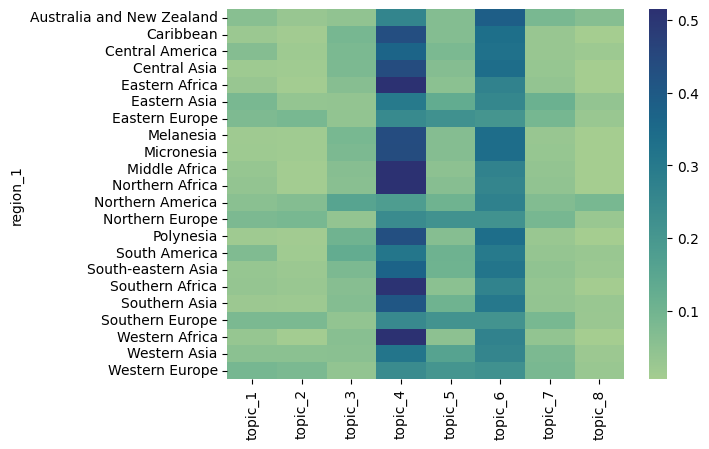

In [72]:
sns.heatmap(hist_data, cmap='crest', robust=True)

# **TF-IDF AND TOPICS PER CLUSTER**

## **TF-IDF**

#### **Running TF-IDF for each cluster**
 Because I want to understand which terms are more important for each cluster, I create subsets of data for each cluster and run TF-IDF on those subsets. Then, I plot a heatmap to visualize the distribution of terms per cluster.

In [73]:
### RUNNING TF-IDF ANALYSIS

# Creating empty dataframe
tf_idf_cluster_terms = pd.DataFrame()

# Calculating TF_IDF for each subset and appending it to a dataset
list_clusters = tfidf_df.cluster_kmean.dropna().unique()
for cluster in list_clusters:
  subset = tfidf_df[tfidf_df['cluster_kmean'] == cluster]
  tfidf_vectorizer = TfidfVectorizer(input='content', stop_words=stop_list)
  tfidf_vector = tfidf_vectorizer.fit_transform(subset['Latest Event Description'])
  tfidf_df_subset = pd.DataFrame(tfidf_vector.toarray(), index=subset['Policy Change ID'], columns=tfidf_vectorizer.get_feature_names_out())
  tfidf_df_subset = tfidf_df_subset.stack().reset_index()
  tfidf_df_subset = tfidf_df_subset.rename(columns={0:'tfidf', 'level_1': 'term'})
  tf_idf_cluster_terms = pd.concat([tf_idf_cluster_terms, tfidf_df_subset])

# Filtering out the terms that have a low tfidf score (below 0.001)
tf_idf_cluster_terms = tf_idf_cluster_terms[tf_idf_cluster_terms['tfidf'] > 0.001]

# Creating new dataset that contains unique pairs of intervention-region
tfidf_df_new = tfidf_df[['Policy Change ID', 'cluster_kmean']].drop_duplicates()

# Merging dataset that contains TF_IDF values with dataset that contains unique pairs of intervention-region
tf_idf_cluster = pd.merge(tf_idf_cluster_terms,tfidf_df_new,on='Policy Change ID')

# Getting top 10 terms with highest TF_IDF per region
top_tfidf = tf_idf_cluster.sort_values(by=['cluster_kmean','tfidf'], ascending=[True,False]).drop_duplicates(subset=['term', 'cluster_kmean']).groupby(['cluster_kmean']).head(10)

In [74]:
### VISUALIZING TF-IDF HEATMAP
#[based on https://github.com/rskrisel/tf-idf/blob/main/README.md]

# Adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# Base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'cluster_kmean:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["cluster_kmean"],
)

# Heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# Text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# Display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

## **TOPIC MODELING**

#### **Training topic modeling model**

In [75]:
# Passing policy descriptions as a list
topic_training_data = ai_policies_df.clean_event_description.to_list()

# Defining the number of topics to return
num_topics = 8

# Defining the number of topic words to print out
num_topic_words = 10

# Initializing the model with seed to get always the same results
model = tp.LDAModel(k=num_topics, seed=42)

# Adding each document to the model, after removing white space (strip)
# and splitting it up into words (split)
for text in topic_training_data:
    model.add_doc(text.strip().split())

# Printing the log-likelihood function to
# derive the maximum likelihood estimator of the parameter
print("Topic Model Training...\n\n")

# Iterating over the data 40 times
iterations = 40
for i in range(0, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

print("\nTopic Model Results:\n\n")
# Printing out top 10 words for each topic
topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number+1}✨\n\n{topic_words}\n")

Topic Model Training...


Iteration: 0	Log-likelihood: -7.581507030345364
Iteration: 1	Log-likelihood: -7.493695987730095
Iteration: 2	Log-likelihood: -7.464114129558229
Iteration: 3	Log-likelihood: -7.441581269536054
Iteration: 4	Log-likelihood: -7.428933354076105
Iteration: 5	Log-likelihood: -7.428313134106953
Iteration: 6	Log-likelihood: -7.4181145066084415


<ipython-input-75-40d2dcb3ada5>:25: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(iterations)


Iteration: 7	Log-likelihood: -7.425687697991197
Iteration: 8	Log-likelihood: -7.415808159879553
Iteration: 9	Log-likelihood: -7.421224371926906
Iteration: 10	Log-likelihood: -7.417572736042145
Iteration: 11	Log-likelihood: -7.42373203386678
Iteration: 12	Log-likelihood: -7.419453381949495
Iteration: 13	Log-likelihood: -7.422617371255068
Iteration: 14	Log-likelihood: -7.427568627354448
Iteration: 15	Log-likelihood: -7.420053947266181
Iteration: 16	Log-likelihood: -7.408635242187451
Iteration: 17	Log-likelihood: -7.413724246337073
Iteration: 18	Log-likelihood: -7.41337260533669
Iteration: 19	Log-likelihood: -7.413625170365029
Iteration: 20	Log-likelihood: -7.413844737533853
Iteration: 21	Log-likelihood: -7.412673413377749
Iteration: 22	Log-likelihood: -7.415652382909972
Iteration: 23	Log-likelihood: -7.407084752063899
Iteration: 24	Log-likelihood: -7.413975548585996
Iteration: 25	Log-likelihood: -7.415992257897199
Iteration: 26	Log-likelihood: -7.407892505634996
Iteration: 27	Log-likelih

#### **Visualizing topic modeling results**

In [76]:
# Creating a dataframe with the results
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]
ai_policies_topics = pd.DataFrame(topic_distributions)

# Joining the dataframe with results with the base dataset
ai_policies_df_topics = ai_policies_df.join(ai_policies_topics)

# Exploding dataset so that each obsevation is at the country-intervention level
ai_policies_country_topics = ai_policies_df_topics.assign(countries=ai_policies_df_topics['Implementing Countries'].str.split(', ')).explode('countries').reset_index(drop=True)

# Merging dataset with country dataset to obtain regions
ai_policies_country_topics = pd.merge(ai_policies_country_topics,df_clusters[['countries', 'cluster_kmean']], on='countries', how="left")

# Renaming columns that refer to topics
dict_topics = {0:"topic_1", 1:"topic_2", 2:"topic_3", 3:"topic_4", 4:"topic_5", 5:"topic_6", 6:"topic_7", 7:"topic_8"}
ai_policies_country_topics = ai_policies_country_topics.rename(columns=dict_topics)

# Dropping column countries and keeping only regions
ai_policies_country_topics = ai_policies_country_topics.drop(columns='countries')

# Slicing dataset so that it contains only the region and topics
ai_policies_country_topics_only = ai_policies_country_topics.iloc[:,num_topics*(-1)-1:]

# Grouping dataset by region, getting the mean of each topic per region
ai_policies_country_topics = ai_policies_country_topics_only.groupby(['cluster_kmean']).mean()

# Creating a dataset to be used for visualization
hist_data = ai_policies_country_topics

<Axes: ylabel='cluster_kmean'>

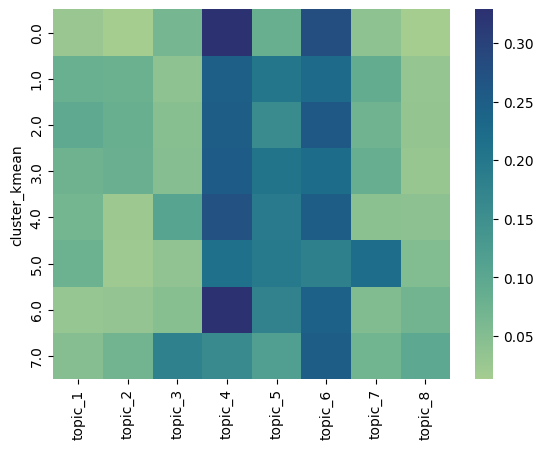

In [77]:
sns.heatmap(hist_data, cmap='crest', robust=True)